In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# matplotlib 한글 꺠짐 방지
# apt-get update
# apt-get install fonts-nanum* 
# apt-get install fontconfig
# fc-cache -fv  # font 캐시 날리기
# rm -rf /root/.cache/matplotlib/  #matplotliob 폰트 캐시 날리기

# jdbc연동에 필요한 jar파일을 클래스 패스와 jar경로에 추가
# /root/spark/conf/spark-default.conf 파일 수정


In [2]:
#!pip install pymysql


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 KB 225.6 kB/s eta 0:00:001m442.6 kB/s eta 0:00:01


In [ ]:
## 새로 user 생성 후 접속해야 함
## DMDB 생성
mysql> create user bigMysql@'%' identified by 'bigMysql1234@';
mysql> grant all privileges on *.* to bigMysql@'%' with grant option;
## 사용할 database 생성
mysql> create database etlMysqlDM;

In [2]:
import pymysql


In [3]:
from datetime import date, datetime
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import *
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt #그래프 패키지 모듈 등록
%matplotlib inline 

## Load - DataMart

## JDBC DICT
- jdbc를 이용한 연결을 위한 기본정보 구성
    - dbms url ?한글처리를 위한 characterset정보&timezone
    - 인증을 위해서 인증정보 넘겨야함. 얘가 props.
      - props: {'user':'', password:''}

In [4]:
JDBC = {
      'url':'jdbc:mysql://localhost:3306/etlMysqlDM?characterEncoding=utf8&serverTimezone=Asia/Seoul'
     ,'props':{
      'user':'bigMysql',
      'password':'bigMysql1234@'   
      }
}

### 1. LOC 테이블 저장
- pipeline code
    - 내용 변경 거의 없는 테이블. 자동화 대상X (airflow연결 제외)

In [5]:
# 면적,인구 data
area = spark.read.csv('/corona_data/tmp/sido_area.csv', encoding='CP949', header=True)
popu = spark.read.csv('/corona_data/tmp/sido_population.csv', encoding='CP949', header=True)

In [6]:
area.show(2)
popu.show(2)

+----+----+-----+
| loc|area|ratio|
+----+----+-----+
|서울|605 |  0.6|
|부산|770 |  0.8|
+----+----+-----+
only showing top 2 rows

+----+---------+---------+---------+
| loc|    total|     male|   female|
+----+---------+---------+---------+
|전국|52739009 |26360035 |26378974 |
|서울| 9736027 | 4721977 | 5014050 |
+----+---------+---------+---------+
only showing top 2 rows



In [7]:
areaPop = area.join(popu, on='loc')\
                .select(col('loc').alias('LOC'),
                        col('area').alias('AREA'),
                        col('total').alias('POPU'))
areaPop.show()
type(areaPop)

[Stage 5:>                                                          (0 + 1) / 1]

+----+------+---------+
| LOC|  AREA|     POPU|
+----+------+---------+
|서울|  605 | 9736027 |
|부산|  770 | 3396109 |
|대구|  883 | 2412642 |
|인천| 1065 | 3014739 |
|광주|  501 | 1462545 |
|대전|  540 | 1469543 |
|울산| 1062 | 1138419 |
|세종|  465 |  376779 |
|경기|10195 |13925862 |
|강원|16830 | 1555876 |
|충북| 7407 | 1633472 |
|충남| 8246 | 2181835 |
|전북| 8070 | 1817186 |
|전남|12348 | 1865459 |
|경북|19034 | 2677709 |
|경남|10541 | 3377331 |
|제주| 1850 |  697476 |
+----+------+---------+



pyspark.sql.dataframe.DataFrame

#### pyspark.sql.dataframe.DataFrame 클래스의 write함수
- 대부분의 data resource로 연결 쓰기 진행 가능
    - dbms, hdfs, fs
- mode라는 함수 연결가능
    - mode() : overwrite (기존 테이블 있으면 새로운 레코드 덮어쓰기, 추가(append)가 아님. 테이블은 두고 레코드만 새로쓰기)
- jdbc로 연결 가능
    - jdbc(url=, table=, properties='연결 인증 data'): dbms에 연결하는 방법을 제시(연결설정을 해주는 함수)
    - url: 어디로 연결?
OO가 DB 열어주고(53분)
mode가 기존 테이블 있는지 없는지 찾고
write가 쓰고

In [10]:
areaPop.write.mode('overwrite').jdbc(url=JDBC['url'], table='LOC', properties=JDBC['props'])

### 2. corona_patient 테이블 저장
- airflow 자동화 예정
- 필요컬럼 추출 후 df저장
- 모든 일자 json파일 읽어와서 df로 생성하고 그 뒤에 필요컬럼 선택하여 df 다시 구성 -> db에 저장
- 매일 새로운data추가되니 기존 table에 append하는 작업 진행되어야함 - append

In [8]:
# 환자 data hdfs(DW) -> df
# spark.read.json('디렉터리명'): 해당 dir의 json을 모두 읽어 df 변환
file_name = 'hdfs://localhost:9000/corona_data/patient/'
coToDF = spark.read.json(file_name, encoding='UTF-8')

In [9]:
# dir내 json 파일 1개가 1개의 행(레코드)으로 구성됨
coToDF.show()

+-----------------------+---------+------+----------+--------------+----------+
|                  items|numOfRows|pageNo|resultCode|     resultMsg|totalCount|
+-----------------------+---------+------+----------+--------------+----------+
| [{326, 40625, 인천,...|      500|     1|        00|NORMAL SERVICE|        19|
|[{45, 7630, 전남, 全...|      500|     1|        00|NORMAL SERVICE|        19|
| [{322, 39970, 인천,...|      500|     1|        00|NORMAL SERVICE|        19|
|[{13, 4897, 제주, 济...|      500|     1|        00|NORMAL SERVICE|        19|
|[{45, 7307, 전남, 全...|      500|     1|        00|NORMAL SERVICE|        19|
|  [{6210, 679030, 합...|      500|     1|        00|NORMAL SERVICE|        19|
+-----------------------+---------+------+----------+--------------+----------+



In [14]:
# items 컬럼 활용해서 DF 다시 생성
# 반환 후 action 모듈: first(), collect()
type(coToDF.select(coToDF.items))
print(len(coToDF.select(coToDF.items).collect()))
print(coToDF.select(coToDF.items).collect())

pyspark.sql.dataframe.DataFrame

6
[Row(items=[Row(deathCnt='326', defCnt='40625', gubun='인천', gubunCn='仁川', gubunEn='Incheon', incDec='196', isolClearCnt='35422', isolIngCnt='0', localOccCnt='177', overFlowCnt='19', qurRate='1378', stdDay='2022-01-18'), Row(deathCnt='123', defCnt='12555', gubun='충북', gubunCn='忠北', gubunEn='Chungcheongbuk-do', incDec='59', isolClearCnt='11766', isolIngCnt='0', localOccCnt='55', overFlowCnt='4', qurRate='786', stdDay='2022-01-18'), Row(deathCnt='110', defCnt='13838', gubun='강원', gubunCn='江原', gubunEn='Gangwon-do', incDec='94', isolClearCnt='12657', isolIngCnt='0', localOccCnt='94', overFlowCnt='0', qurRate='899', stdDay='2022-01-18'), Row(deathCnt='344', defCnt='28102', gubun='부산', gubunCn='釜山', gubunEn='Busan', incDec='114', isolClearCnt='25796', isolIngCnt='0', localOccCnt='102', overFlowCnt='12', qurRate='839', stdDay='2022-01-18'), Row(deathCnt='65', defCnt='7459', gubun='울산', gubunCn='蔚山', gubunEn='Ulsan', incDec='35', isolClearCnt='7107', isolIngCnt='0', localOccCnt='33', overFlo

In [15]:
coToDF.select(coToDF.items).collect()[0]

Row(items=[Row(deathCnt='326', defCnt='40625', gubun='인천', gubunCn='仁川', gubunEn='Incheon', incDec='196', isolClearCnt='35422', isolIngCnt='0', localOccCnt='177', overFlowCnt='19', qurRate='1378', stdDay='2022-01-18'), Row(deathCnt='123', defCnt='12555', gubun='충북', gubunCn='忠北', gubunEn='Chungcheongbuk-do', incDec='59', isolClearCnt='11766', isolIngCnt='0', localOccCnt='55', overFlowCnt='4', qurRate='786', stdDay='2022-01-18'), Row(deathCnt='110', defCnt='13838', gubun='강원', gubunCn='江原', gubunEn='Gangwon-do', incDec='94', isolClearCnt='12657', isolIngCnt='0', localOccCnt='94', overFlowCnt='0', qurRate='899', stdDay='2022-01-18'), Row(deathCnt='344', defCnt='28102', gubun='부산', gubunCn='釜山', gubunEn='Busan', incDec='114', isolClearCnt='25796', isolIngCnt='0', localOccCnt='102', overFlowCnt='12', qurRate='839', stdDay='2022-01-18'), Row(deathCnt='65', defCnt='7459', gubun='울산', gubunCn='蔚山', gubunEn='Ulsan', incDec='35', isolClearCnt='7107', isolIngCnt='0', localOccCnt='33', overFlowCn

In [16]:
# 각 날짜에 대한 지역별 레코드 구성
# 리스트에 레코드 저장 후 df로 구성
# collect()로 반환 받은 후에 진행하거나
# spark.sql.toLocalIterator(): df에서 각 레코드를 반환해주는 역할을 하는 함수: df에 적용되면 row객체 반환
data=[]
for rdd1 in coToDF.select(coToDF.items).toLocalIterator():
    # item: 특정 일에 대한 특정 지역의 data
    for item in rdd1.items:
        data.append(item)

[Stage 14:>                                                         (0 + 1) / 1]

In [17]:
len(data)

114

In [18]:
tmpDF = spark.createDataFrame(data)

In [21]:
tmpDF.show(50)

[Stage 22:>                                                         (0 + 1) / 1]

+--------+------+-----+-------+-----------------+------+------------+----------+-----------+-----------+-------+----------+
|deathCnt|defCnt|gubun|gubunCn|          gubunEn|incDec|isolClearCnt|isolIngCnt|localOccCnt|overFlowCnt|qurRate|    stdDay|
+--------+------+-----+-------+-----------------+------+------------+----------+-----------+-----------+-------+----------+
|     326| 40625| 인천|   仁川|          Incheon|   196|       35422|         0|        177|         19|   1378|2022-01-18|
|     123| 12555| 충북|   忠北|Chungcheongbuk-do|    59|       11766|         0|         55|          4|    786|2022-01-18|
|     110| 13838| 강원|   江原|       Gangwon-do|    94|       12657|         0|         94|          0|    899|2022-01-18|
|     344| 28102| 부산|   釜山|            Busan|   114|       25796|         0|        102|         12|    839|2022-01-18|
|      65|  7459| 울산|   蔚山|            Ulsan|    35|        7107|         0|         33|          2|    665|2022-01-18|
|      60| 10475| 광주|   光州| 

In [22]:
tmpDF.columns

['deathCnt',
 'defCnt',
 'gubun',
 'gubunCn',
 'gubunEn',
 'incDec',
 'isolClearCnt',
 'isolIngCnt',
 'localOccCnt',
 'overFlowCnt',
 'qurRate',
 'stdDay']

In [29]:
# 주석복사필요
coPDF = tmpDF.select(
    tmpDF.gubun.alias('LOC'),
    tmpDF.deathCnt.alias('DEATH_CNT'),
    tmpDF.defCnt.alias('DEF_CNT'),
    tmpDF.localOccCnt.alias('LOC_OCC_CNT'),
    tmpDF.qurRate.alias('QUR_RATE'),
    tmpDF.stdDay.alias('STD_DAY'),
)\
.where(~(col('LOC').isin(['합계','검역']))).distinct() #불필요한 행 제거

- mode : append (기존 테이블 있으면 테이블에 레코드 추가)

In [31]:
coPDF.where(col('STD_DAY')=='2022-01-18').show()

[Stage 26:>                                                         (0 + 1) / 1]

+----+---------+-------+-----------+--------+----------+
| LOC|DEATH_CNT|DEF_CNT|LOC_OCC_CNT|QUR_RATE|   STD_DAY|
+----+---------+-------+-----------+--------+----------+
|강원|      110|  13838|         94|     899|2022-01-18|
|서울|     2063| 243337|        684|    2559|2022-01-18|
|대전|      187|  13262|        101|     913|2022-01-18|
|전북|      121|  11245|        147|     629|2022-01-18|
|경기|     2036| 210984|       1470|    1555|2022-01-18|
|경남|      114|  22778|        134|     687|2022-01-18|
|광주|       60|  10475|        174|     727|2022-01-18|
|전남|       45|   7935|        138|     433|2022-01-18|
|세종|        4|   2388|         21|     642|2022-01-18|
|충남|      177|  20142|        140|     950|2022-01-18|
|경북|      189|  16962|        129|     646|2022-01-18|
|울산|       65|   7459|         33|     665|2022-01-18|
|대구|      385|  25155|        162|    1055|2022-01-18|
|부산|      344|  28102|        102|     839|2022-01-18|
|인천|      326|  40625|        177|    1378|2022-01-18|
|제주|

In [32]:
coPDF.write.jdbc(url=JDBC['url'], table='CORONA_PATIENTS', mode='append', properties=JDBC['props'])

### 3.  CORONA_VACCINE 테이블 저장

In [5]:
# vaccine 폴더 내에 있는 json파일 모두 읽어오기
file_name= '/corona_data/vaccine/'
vaccine = spark.read.json(file_name, encoding='UTF-8')
vaccine.show()

[Stage 2:>                                                          (0 + 1) / 1]

+----------------------+---------------------------+
|                  data|                       meta|
+----------------------+---------------------------+
|[{세종, 290049, 281...|{{지역, 1차 접종 누적, 2...|
|[{울산, 956453, 930...|{{지역, 1차 접종 누적, 2...|
|[{대전, 1230930, 12...|{{지역, 1차 접종 누적, 2...|
|[{광주, 1247764, 12...|{{지역, 1차 접종 누적, 2...|
|[{울산, 955163, 925...|{{지역, 1차 접종 누적, 2...|
|[{울산, 955638, 927...|{{지역, 1차 접종 누적, 2...|
+----------------------+---------------------------+



In [6]:
vaccine.select(vaccine.data.loc.alias('LOC'), vaccine.meta.stdDay).show()

[Stage 4:>                                                          (0 + 1) / 1]

+----------------------------+-----------+
|                         LOC|meta.stdDay|
+----------------------------+-----------+
|[세종, 광주, 인천, 대전, ...| 2022-01-15|
|[울산, 대전, 인천, 광주, ...| 2022-01-16|
|[대전, 울산, 광주, 인천, ...| 2022-01-17|
|[광주, 울산, 인천, 대전, ...| 2022-01-18|
|[울산, 대전, 광주, 인천, ...| 2022-01-13|
|[울산, 대전, 광주, 인천, ...| 2022-01-14|
+----------------------------+-----------+



In [7]:
# vaccine data는 기준일 stdDay가 meta컬럼에
tmpData=[]
for rdd1 in vaccine.select(vaccine.data, vaccine.meta.stdDay).toLocalIterator():
    for data in rdd1.data:
        temp = data.asDict() #특정일의 한 지역의 data: dict객체
        temp['std_day']=rdd1['meta.stdDay'] #데이터수집 기준일을 지역data에 포함: dict객체 -> 참조변수
        tmpData.append(Row(**temp)) # dict->row

[Stage 6:>                                                          (0 + 1) / 1]

In [8]:
tmpData

[Row(loc='세종', v1='290049', v2='281209.0', v3='133791.0', std_day='2022-01-15'),
 Row(loc='광주', v1='1246812', v2='1217198.0', v3='661037.0', std_day='2022-01-15'),
 Row(loc='인천', v1='2530654', v2='2478165.0', v3='1282656.0', std_day='2022-01-15'),
 Row(loc='대전', v1='1230543', v2='1200346.0', v3='609202.0', std_day='2022-01-15'),
 Row(loc='대구', v1='1995815', v2='1939414.0', v3='948537.0', std_day='2022-01-15'),
 Row(loc='부산', v1='2847265', v2='2781230.0', v3='1511528.0', std_day='2022-01-15'),
 Row(loc='서울', v1='8234238', v2='8073652.0', v3='4175126.0', std_day='2022-01-15'),
 Row(loc='전국', v1='44471225', v2='43472288.0', v3='23015954.0', std_day='2022-01-15'),
 Row(loc='울산', v1='956188', v2='930201.0', v3='461140.0', std_day='2022-01-15'),
 Row(loc='경기', v1='11642409', v2='11384397.0', v3='5758621.0', std_day='2022-01-15'),
 Row(loc='제주', v1='580074', v2='565008.0', v3='287633.0', std_day='2022-01-15'),
 Row(loc='경남', v1='2846130', v2='2776414.0', v3='1474593.0', std_day='2022-01-15'),

In [9]:
vacTmp = spark.createDataFrame(tmpData)
vacTmp.show()

+----+--------+----------+----------+----------+
| loc|      v1|        v2|        v3|   std_day|
+----+--------+----------+----------+----------+
|세종|  290049|  281209.0|  133791.0|2022-01-15|
|광주| 1246812| 1217198.0|  661037.0|2022-01-15|
|인천| 2530654| 2478165.0| 1282656.0|2022-01-15|
|대전| 1230543| 1200346.0|  609202.0|2022-01-15|
|대구| 1995815| 1939414.0|  948537.0|2022-01-15|
|부산| 2847265| 2781230.0| 1511528.0|2022-01-15|
|서울| 8234238| 8073652.0| 4175126.0|2022-01-15|
|전국|44471225|43472288.0|23015954.0|2022-01-15|
|울산|  956188|  930201.0|  461140.0|2022-01-15|
|경기|11642409|11384397.0| 5758621.0|2022-01-15|
|제주|  580074|  565008.0|  287633.0|2022-01-15|
|경남| 2846130| 2776414.0| 1474593.0|2022-01-15|
|경북| 2259004| 2196640.0| 1215461.0|2022-01-15|
|전남| 1631047| 1599517.0| 1007985.0|2022-01-15|
|전북| 1573966| 1543969.0|  933145.0|2022-01-15|
|충남| 1868511| 1825332.0| 1017953.0|2022-01-15|
|충북| 1407536| 1375764.0|  760611.0|2022-01-15|
|강원| 1330984| 1303832.0|  776935.0|2022-01-15|
|울산|  9

In [10]:
coVacDF = vacTmp.where(~(col('loc').isin(['전국','기타']))).distinct()

In [11]:
coVacDF.show()

[Stage 10:>                                                         (0 + 1) / 1]

+----+--------+----------+---------+----------+
| loc|      v1|        v2|       v3|   std_day|
+----+--------+----------+---------+----------+
|충북| 1408620| 1379378.0| 783588.0|2022-01-18|
|경북| 2257551| 2191750.0|1189288.0|2022-01-14|
|경기|11635521|11361626.0|5594786.0|2022-01-14|
|충남| 1867376| 1821328.0| 993122.0|2022-01-14|
|강원| 1330362| 1301351.0| 760673.0|2022-01-14|
|울산|  955638|  927850.0| 448125.0|2022-01-14|
|대구| 1993851| 1929408.0| 911366.0|2022-01-13|
|부산| 2845893| 2774965.0|1478167.0|2022-01-14|
|광주| 1247764| 1220758.0| 682394.0|2022-01-18|
|경기|11652853|11414202.0|5970505.0|2022-01-18|
|경북| 2256335| 2187682.0|1171548.0|2022-01-13|
|전북| 1572742| 1537974.0| 901988.0|2022-01-13|
|부산| 2849093| 2788089.0|1554554.0|2022-01-18|
|세종|  289820|  280462.0| 130110.0|2022-01-14|
|충남| 1866552| 1817963.0| 978013.0|2022-01-13|
|경남| 2848083| 2783896.0|1517240.0|2022-01-18|
|경기|11630764|11342341.0|5506349.0|2022-01-13|
|울산|  955163|  925527.0| 438364.0|2022-01-13|
|광주| 1245589| 1210797.0| 627

In [12]:
# 주석
pdcoVac = coVacDF.pandas_api()
pdcoVac.head()
type(pdcoVac)

/root/spark/python/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(
                                                                                

,loc,v1,v2,v3,std_day
0,충남,1868511,1825332.0,1017953.0,2022-01-15
1,부산,2847993,2783249.0,1531196.0,2022-01-16
2,충남,1869192,1826570.0,1031055.0,2022-01-16
3,충북,1408019,1376810.0,771144.0,2022-01-17
4,경남,2846130,2776414.0,1474593.0,2022-01-15


pyspark.pandas.frame.DataFrame

In [13]:
# 행 idx는 dbms 테이블의 기본키와 같은 역할
pdcoVac = pdcoVac.set_index(['loc','std_day'])
pdcoVac.head()

,,v1,v2,v3
loc,std_day,,,
충남,2022-01-15,1868511,1825332.0,1017953.0
부산,2022-01-16,2847993,2783249.0,1531196.0
충남,2022-01-16,1869192,1826570.0,1031055.0
충북,2022-01-17,1408019,1376810.0,771144.0
경남,2022-01-15,2846130,2776414.0,1474593.0


In [14]:
pdcoVacV1 = pdcoVac.stack()
pdcoVacV1
type(pdcoVacV1)

loc  std_day       
충북   2022-01-18  v2     1379378.0
                 v1       1408620
                 v3      783588.0
경북   2022-01-14  v2     2191750.0
                 v1       2257551
                 v3     1189288.0
경기   2022-01-14  v2    11361626.0
                 v1      11635521
                 v3     5594786.0
충남   2022-01-14  v2     1821328.0
                 v1       1867376
                 v3      993122.0
강원   2022-01-14  v2     1301351.0
                 v1       1330362
                 v3      760673.0
울산   2022-01-14  v2      927850.0
                 v1        955638
                 v3      448125.0
대구   2022-01-13  v2     1929408.0
                 v1       1993851
                 v3      911366.0
부산   2022-01-14  v2     2774965.0
                 v1       2845893
                 v3     1478167.0
광주   2022-01-18  v2     1220758.0
                 v1       1247764
                 v3      682394.0
경기   2022-01-18  v2    11414202.0
                 v1      116

pyspark.pandas.series.Series

In [15]:
pdcoVac = pdcoVacV1.to_dataframe('V_CNT')
pdcoVac.index

MultiIndex([('충북', '2022-01-18', 'v2'),
            ('충북', '2022-01-18', 'v1'),
            ('충북', '2022-01-18', 'v3'),
            ('경북', '2022-01-14', 'v2'),
            ('경북', '2022-01-14', 'v1'),
            ('경북', '2022-01-14', 'v3'),
            ('경기', '2022-01-14', 'v2'),
            ('경기', '2022-01-14', 'v1'),
            ('경기', '2022-01-14', 'v3'),
            ('충남', '2022-01-14', 'v2'),
            ...
            ('전남', '2022-01-16', 'v3'),
            ('경북', '2022-01-15', 'v2'),
            ('경북', '2022-01-15', 'v1'),
            ('경북', '2022-01-15', 'v3'),
            ('대전', '2022-01-17', 'v2'),
            ('대전', '2022-01-17', 'v1'),
            ('대전', '2022-01-17', 'v3'),
            ('경북', '2022-01-16', 'v2'),
            ('경북', '2022-01-16', 'v1'),
            ('경북', '2022-01-16', 'v3')],
           names=['loc', 'std_day', None], length=306)

In [16]:
pdcoVac = pdcoVac.reset_index()
pdcoVac.head()

,loc,std_day,level_2,V_CNT
0,충북,2022-01-18,v2,1379378.0
1,충북,2022-01-18,v1,1408620
2,충북,2022-01-18,v3,783588.0
3,경북,2022-01-14,v2,2191750.0
4,경북,2022-01-14,v1,2257551


In [17]:
pdcoVac = pdcoVac.rename(columns={"level_2":"V_TH","loc":"LOC", "std_day":"STD_DAY"})

In [18]:
# pd df -> spark sql db
coVacDFv1 = pdcoVac.to_spark()
coVacDFv1.show() # 몇차접종인지에 대한 값이 df컬럼의 value로 구성

/root/spark/python/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
[Stage 26:=============================>                            (1 + 1) / 2]

+----+----------+----+---------+
| LOC|   STD_DAY|V_TH|    V_CNT|
+----+----------+----+---------+
|충남|2022-01-15|  v2|1825332.0|
|충남|2022-01-15|  v1|  1868511|
|충남|2022-01-15|  v3|1017953.0|
|부산|2022-01-16|  v2|2783249.0|
|부산|2022-01-16|  v1|  2847993|
|부산|2022-01-16|  v3|1531196.0|
|충남|2022-01-16|  v2|1826570.0|
|충남|2022-01-16|  v1|  1869192|
|충남|2022-01-16|  v3|1031055.0|
|충북|2022-01-17|  v2|1376810.0|
|충북|2022-01-17|  v1|  1408019|
|충북|2022-01-17|  v3| 771144.0|
|경남|2022-01-15|  v2|2776414.0|
|경남|2022-01-15|  v1|  2846130|
|경남|2022-01-15|  v3|1474593.0|
|전남|2022-01-17|  v2|1600290.0|
|전남|2022-01-17|  v1|  1631390|
|전남|2022-01-17|  v3|1017226.0|
|세종|2022-01-17|  v2| 281703.0|
|세종|2022-01-17|  v1|   290304|
+----+----------+----+---------+
only showing top 20 rows



In [23]:
coVacDFv1.printSchema()

root
 |-- LOC: string (nullable = true)
 |-- STD_DAY: string (nullable = true)
 |-- V_TH: string (nullable = false)
 |-- V_CNT: string (nullable = true)



In [26]:
coVacDFv1.write.jdbc(url=JDBC['url'], table='CORONA_VACCINE', mode='append', properties=JDBC['props'])

### 4. LOC_FACILITY_CNT	테이블 저장
- 주기적 수집 data X
- 파일 자료가 다중이용시설 상호별로 되어있음
- 광역시도별 개수 세어서 저장

In [24]:
# https://www.data.go.kr/data/15093402/fileData.do#tab-layer-file
facil = spark.read.csv('/corona_data/tmp/전국다중이용시설.csv', encoding='CP949', header=True)

In [25]:
facil.show(5)

+----+----+------+------------------+--------------+----------------+
|연도|광역|시군구|            시설명|사업자등록번호|          시설군|
+----+----+------+------------------+--------------+----------------+
|2020|강원|강릉시|  (주)경포솔향온천|  127-86-57613|          목욕장|
|2020|강원|강릉시|    24시황실사우나|  226-33-03247|          목욕장|
|2020|강원|강릉시|      강릉고려병원|  226-82-03662|        의료기관|
|2020|강원|강릉시|강릉고속버스터미널|  219-81-01636|여객자동차터미널|
|2020|강원|강릉시|    강릉교육문화관|  226-83-03107|          도서관|
+----+----+------+------------------+--------------+----------------+
only showing top 5 rows



In [26]:
facCnt = facil.groupby(col('광역').alias('LOC'))\
              .agg(count('*').alias('FAC_CNT'))  #모여있는 레코드 자체가 몇개인지 세는 코드

In [27]:
facCnt.printSchema()
facCnt.show(1)

root
 |-- LOC: string (nullable = true)
 |-- FAC_CNT: long (nullable = false)



[Stage 43:>                                                         (0 + 1) / 1]

+----+-------+
| LOC|FAC_CNT|
+----+-------+
|경북|    944|
+----+-------+
only showing top 1 row



In [30]:
facCnt.write.jdbc(url=JDBC['url'], table='LOC_FACILITY', mode='overwrite', properties=JDBC['props'])

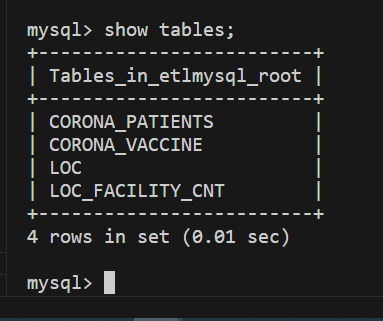